# CLASIFICADOR . LDR

**AUTOR:** José Manuel Marín Noguera

**Proyecto:** Clasificar diagnosticos clinicos

**Enero 2016** 

## Objetivo
   
-Construir un clasificador de diagnosticos clinicos cie9 con tecnica LDR.

### Tareas

    CARGA.
    PREPARACION.
    VECTORIZA.
    MODELO.
    EVALUACION.
    PREDICCION.
    INTEGRACION.
    
--Nos apoyamos en pandas  y sus data frame para la tarea de preparacion ejemplos.

--Nos apoyamos en sklearn para vectorizar textos, modelizar.
_______________________________________________________________________________________________________________________

##  INICIO

In [1]:
# -*- coding: utf-8 -*-
#importar la libreria NLTK para manejo de texto en python
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk import FreqDist

from string import punctuation #Importar simbolos puntuacion del ingles
import unicodedata #Para quitar tildes

#Importar lo las funciones, clases y algoritmos que utilizaremos de Scikit-Learn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler, LabelEncoder,normalize
from sklearn.model_selection import StratifiedShuffleSplit,KFold,cross_val_score,cross_val_predict,train_test_split
#from sklearn import decomposition, pipeline, metrics, grid_search
from sklearn.externals import joblib
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#import gensim 
#from gensim.models import word2vec, Phrases ,doc2vec
from gensim.models import doc2vec
from gensim.models.doc2vec import TaggedDocument,LabeledSentence

#Importar la libreria PANDAS para el manejo de datos
import pandas as pd
pd.set_option('max_colwidth',1000)#Para que los textos se vean enteros

from scipy.sparse import hstack #Importar la funcion de matriz no densa de scipy

import numpy as np #Importar para trabajar con matrizes que utiliza el pandas.

#Importar la libreria para manipulacion de XML
import xml.etree.ElementTree as ET

#Importar el modulo de expresiones regulares y de strings
import re
import string

#Importar para sacar tiempos
import time
import datetime

import gc #Para gestionar la memoria

import logging #Importar gestion de logs.

import os # Import para intereacion con el sistema

#Importar para visualizar
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

### Resultados Estudios

In [2]:
#Exploracion
def add_estudio(dx,dfx):
    dfl = pd.DataFrame([dx])
    dfx = dfx.append(dfl, ignore_index=True)         
    return dfx
#columnas=columnas
columnas = ['estudio','fecha','clasificador', 'version'
            ,'dataset', 'ejemplos', 'clases','palabras','vocablos'
            ,'vector', 'vparameros', 'vtiempo'
            ,'corte','sejemplos', 'sclases', 'sfeatures'  
            ,'modelo', 'mparametros','evaluacion','etipo', 'accuracy','top_prob']
df_estudio = pd.DataFrame(columns=columnas) 
d_estudio = {'clasificador' : 'idc.ml.ldr'
              , 'version': 'v1.0.0'
              , 'estudio': 'clasificadores'
              , 'fecha': datetime.datetime.now().date()
              }
#d_estudio.update ({'accuracy': 0.95})
#df_estudio=add_estudio(d_estudio,df_estudio)# Grabar despoes de nuevo dato


## OBTENER DATOS
### Carga

In [3]:
# Mecanismo de log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
# Ficheros
fichero_cat = 'CIE9_1.csv'
fichero_dat = 'MIR_2009-distutf8.csv'

In [5]:
# Catalogo de estudios previos
df_cat = pd.read_csv(fichero_cat, encoding='utf-8', sep='\t', index_col=False, header=None,names=['clase','texto'])
df_cat.head()

,clase,texto
0,001,COLERA
1,001.0,COLERA DEBIDA A VIBRIO CHOLERAE
2,001.1,COLERA DEBIDA A VIBRIO CHOLERAE EL TOR
3,001.9,"COLERA, SIN ESPECIFICAR"
4,002,FIEBRES TIFOIDEAS Y PARATIFOIDEAS


In [6]:
# Juego de datos para el estudio
df = pd.read_csv(fichero_dat, encoding='utf-8', header=0,infer_datetime_format=True)
#Cambiamos nombres de columnas
df=df.rename(columns = {'cie9':'clase'})
df=df.rename(columns = {'diag textual':'texto'})
#Quitamos lo que no son diagnosticos
df = df.query('clase != "V53.31"')
df = df.query('clase != "V54.01"')
#Quitamos los que no tienen texto
df=df.dropna(subset=['texto'])
#Se decide no trabajar solo con los textos se eliminan las colunas sexo y fechanac
df = df.drop('sexo',axis = 1)
df = df.drop('fechanac',axis = 1)
df.head()

,clase,texto
0,3,GEA POR SALMONELLA
1,3,GEA SEVERA CON PRODUCTOS PATOLOGICOS
2,3,- GASTROENTERITIS AGUDA POR SALMONELLA SP
3,4.9,DIARREA ETIOLOGIA INFECCIOSA.PROBABLE VIH
4,5.9,VOMITOS. DESHIDRATACION LEVE. BRONCOESPASMO. INSUF. SUPRARRENAL.


In [7]:
# Un catalogo diferente en textos del CIE.9
df_cie9 = pd.read_csv('CIE9MC.csv', encoding='utf-8', sep=',', index_col=False, )
df_cie9 = df_cie9.rename(columns = {'Id9':'clase'})
df_cie9 = df_cie9.rename(columns = {'Desc9':'texto'})
df_cie9 = df_cie9.drop('IdRel',axis = 1)
df_cie9 = df_cie9.drop('sdfd',axis = 1)
#Por si queremos trabajar con los titulos de los capitulos
#df_cie9_cap = df_cie9[df_cie9['clase'].isnull()]
df_cie9 = df_cie9[df_cie9.index<14504]#Quita capitulos 20 y 21
df_cie9 = df_cie9[df_cie9['clase'].notnull()]
df_cie9.head()

,clase,texto
3,001,COLERA
4,001.0,COLERA.POR VIBRIO CHOLERAE
5,001.1,COLERA.POR VIBRIO CHOLERAE EL TOR
6,001.9,COLERA.NEOM
7,002,FIEBRE TIFOIDEA Y PARATIFOIDEA


### Descripcion datos

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2940 entries, 0 to 2950
Data columns (total 2 columns):
clase    2940 non-null object
texto    2940 non-null object
dtypes: object(2)
memory usage: 68.9+ KB


In [9]:
df.describe(include=['O'])

,clase,texto
count,2940,2940
unique,547,2601
top,428,INSUFICIENCIA CARDIACA CONGESTIVA
freq,222,14


In [10]:
#catalogos
print ('Catalogo CIE9 Version 1 Nº de registros',df_cat.shape[0])
print ('Catalogo CIE9 Version 2 Nº de registros',df_cie9.shape[0])

Catalogo CIE9 Version 1 Nº de registros 14733
Catalogo CIE9 Version 2 Nº de registros 14376


In [11]:
#DATOS GUARDAR ESTUDIO
d_estudio.update ({'dataset': fichero_dat})
d_estudio.update ({'ejemplos': df.shape[0]})
d_estudio.update ({'clases': len(df.clase.unique())})

In [12]:
#df_cat.describe(include=['O'])

## PROCESADO DOCUMENTOS
### Tokenizado 

In [13]:
#  Funciones para adecuacion de los tokenizadores 
non_words = list(punctuation)
#Añadimos  punctuation castellano + letras sueltas + numeros
non_words.extend(['¿', '¡','...','..','<br />','<t />'])
non_words.extend(['a','b','c','d','e','f','g','h','i','j','k','l','m','n','ñ','o','p','q','r','s','t','u','v','w','x','y','z'])
#non_words.extend(map(str,range(10000)))
non_words.extend(['de', 'por','con','en','la','1.'])
spanish_stopwords = stopwords.words('spanish')
non_words.extend(spanish_stopwords)
def my_tokenize(text):
    text = text.lower()
    text = ''.join((c for c in unicodedata.normalize('NFD',text) if unicodedata.category(c) != 'Mn'))
    #tk = text.split()
    tk = word_tokenize(text,language='spanish')
    tk = [c for c in tk if c not in non_words] # Quitamos non_words
    return tk   

#Exploracion
def acumula_fdist(dfx):
    docs=dfx.tolist()
    docs=[item for sublist in docs for item in sublist]
    fdist=FreqDist(docs)
    return fdist

### Preproceso para vectorizar

In [14]:
# Contar terminos totales por ejemplo
def total_terminos(df_ejemplos):
    df_ejemplos['words'] = df_ejemplos.texto.map(my_tokenize)
    df_ejemplos['Td'] = df_ejemplos['words'].apply(len)
    return df_ejemplos

In [15]:
# Añadimos caracteristicas necesarias
corpus_textos_cat = df_cat.copy()
corpus_textos_df = df.copy()
corpus_textos_cie9 = df_cie9.copy()

corpus_textos_df = total_terminos(corpus_textos_df)
corpus_textos_cat = total_terminos(corpus_textos_cat)
corpus_textos_cie9 = total_terminos(corpus_textos_cie9)

shuffle(corpus_textos_df).head()

,clase,texto,words,Td
2347,577.8,ITU.SEPSIS,[itu.sepsis],1
2618,707.03,ULCERA DECUBITO. AC X FA.,"[ulcera, decubito, ac, fa]",4
1059,453.41,TVP FEMORAL MID,"[tvp, femoral, mid]",3
1224,481,BRONQUIECTASIAS RESPIRATORIAS POR S PNEUMONIAE,"[bronquiectasias, respiratorias, pneumoniae]",3
2257,558.9,1-GASTROENTERITIS AGUDA LIMITADA,"[1-gastroenteritis, aguda, limitada]",3


Longitud media de frase: 4.62 (+/- 5.45)

Nº de palabras del corpus 13597
Nº de palabras del vocabulario 2713


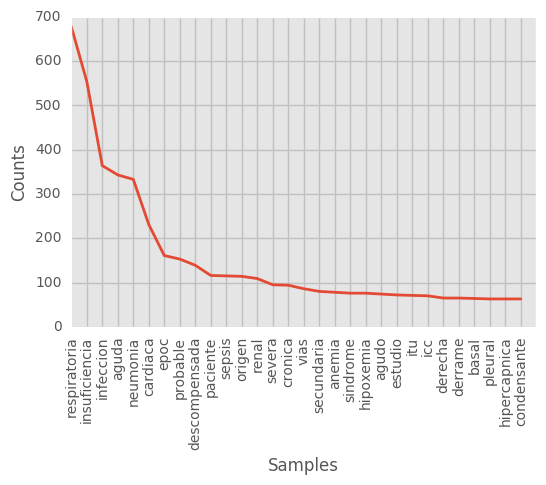

In [18]:
#np.mean(len(corpus_textos_df.labs))
print("Longitud media de frase: %0.2f (+/- %0.2f)\n" % (np.mean(corpus_textos_df['words'].apply(len))
                                                , np.std(corpus_textos_df['words'].apply(len)) * 2))
fdist = acumula_fdist(corpus_textos_df.words)
print ('Nº de palabras del corpus',fdist.N())
print ('Nº de palabras del vocabulario',len(fdist.keys()))
fdist.plot(30)

In [19]:
#DATOS GUARDAR ESTUDIO
d_estudio.update ({'palabras': fdist.N()})
d_estudio.update ({'vocablos': len(fdist.keys())})

### Transformacion LDR

In [74]:
#Funcion que tranforma al vector de caracteristicas por clase Fci(W)
def Vcc(vec,i,v_Td):
    r=np.zeros(6)
    r[0]=np.mean(vec) # Media
    r[1]=np.std(vec) # Desviacion tipica
    r[2]=np.min(vec) # Minimo
    r[3]=np.max(vec) # Minimo
    r[4]=np.mean(vec)/v_Td[i] # Prob
    r[5]=np.sum(len(vec))/v_Td[i] # Prop
    return r
#Definimos el numero de caracteristicas
num_medidas = 6

In [75]:
# Funcion Vector LDR
def transform_ldr(a_tfidf,a_wtc,v_Td):
    #Matriz con los terminos del vocabulario por documento
    a_vocablos= a_tfidf>0
    #Inicializamos un matriza vacia.
    a_ldr = np.zeros((a_vocablos.shape[0],num_medidas*a_wtc.shape[0]))
    for index,v_vocablos in enumerate(a_vocablos):
        if np.any(v_vocablos):
            v = np.empty(0) 
            for v_wtc in a_wtc:
                v =np.hstack((v,Vcc(v_wtc[v_vocablos],index,v_Td)))          
        else:
            v = np.zeros(num_medidas*a_wtc.shape[0])   
        a_ldr[index]=v
    return a_ldr

In [126]:
# Funcion Transforma LDR
def fit_transform_ldr(dfx,a_tfidf):
    Wtc = Wtc_ldr(dfx,a_tfidf)# Calculo de la matriz de pesos W(t,c)
    X_vec = transform_ldr(a_tfidf ,Wtc ,dfx.Td.values )# Vectoriza(reduce dimensionalidad) con LDR
    return X_vec,Wtc

In [128]:
# Funcion Transforma LDR
le = LabelEncoder()
def Wtc_ldr(dfx,a_tfidf):       
    l_clases = le.fit_transform(dfx.clase)
    Y_clases = le.transform(dfx.clase)
    def Wtermino(a):
        return np.bincount(Y_clases,  weights=a)/np.sum(a)
    Wtc = np.apply_along_axis(Wtermino, 0, a_tfidf)#Matriz con los pesos Wtc por termino.
    return Wtc

In [21]:
#DATOS GUARDAR ESTUDIO
d_estudio.update ({'vector': 'ldr'})
d_estudio.update ({'vparameros': 'word,binary,min_df=1,my_tokenize'})
d_estudio.update ({'vtiempo': 0 })                               

## MODELOS
### Preproceso Modelos

In [22]:
def frecuentes(df_ejemplos,corte):
    # Filtrado Clases mas usadas .Hay muchas clases con pocos ejemplos, entonces establecemos un minimo
    df_frecuente=df_ejemplos.clase.value_counts() 
    df_frecuente=df_frecuente[df_ejemplos.clase.value_counts()>corte]
    return df_ejemplos[df_ejemplos.clase.isin(df_frecuente.index)]

In [23]:
def mas_catalogo(df_ejemplos,df_catalogo):
    df_mas_catalogo=df_ejemplos.copy()     
    for iclase in np.unique(df_ejemplos.clase): 
        df_clase = df_catalogo[df_catalogo['clase'] == iclase]           
        df_mas_catalogo = pd.concat([df_mas_catalogo, df_clase])
    return df_mas_catalogo

In [24]:
def balance_clases(df_ejemplos):
    df_balanceado=df_ejemplos.copy()
    #ejemplos=df_ejemplos.clase.value_counts().max()
    ejemplos = 30
    for iclase in np.unique(df_ejemplos.clase): 
        df_clase = df_ejemplos[df_ejemplos['clase'] == iclase]
        if df_clase.shape[0]<ejemplos :
            df_clase_artificial = df_clase.sample(n=(ejemplos-len(df_clase)), replace=True ,random_state=1)   
            df_balanceado = pd.concat([df_balanceado, df_clase_artificial])
        else:
            df_balanceado = pd.concat([df_balanceado, df_clase])
    return df_balanceado

In [25]:
def prepara_ejemplos(df_ejemplos):
    df_ejemplos = mas_catalogo(df_ejemplos,corpus_textos_cat)
    df_ejemplos = mas_catalogo(df_ejemplos,corpus_textos_cie9)
    #df_ejemplos = balance_clases(df_ejemplos)
    return df_ejemplos

In [26]:
df_copia=corpus_textos_df.copy()

### Filtrado vista minable

In [201]:
#Ejemplo de preparacion 
#df_balance = prepara_ejemplos(corpus_textos_df)
#Quitamos los no significativos
corte = 30
corpus_textos_df = frecuentes(df_copia,corte)

In [202]:
corpus_textos_df.clase.describe(include=['O'])

count     1516
unique      16
top        428
freq       222
Name: clase, dtype: object

Nº de palabras del corpus 6852
Nº de palabras del vocabulario 1284


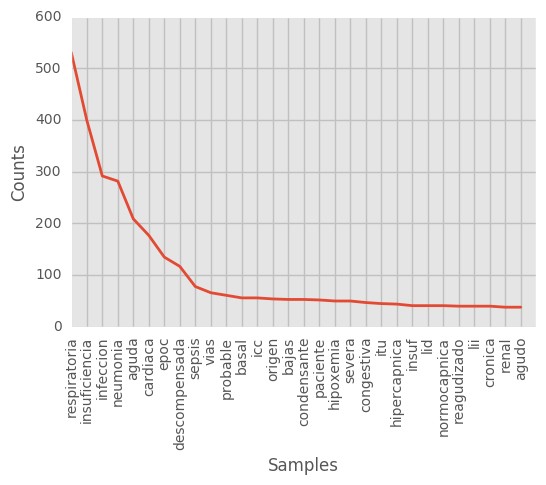

In [203]:
fdist = acumula_fdist(corpus_textos_df.words)
print ('Nº de palabras del corpus',fdist.N())
print ('Nº de palabras del vocabulario',len(fdist.keys()))
fdist.plot(30)

In [32]:
#corpus_textos_df.clase.value_counts(sort=True, ascending=False, bins=None, dropna=True)

In [33]:
#corpus_textos_df.clase.value_counts(sort=True, ascending=False, bins=None, dropna=True)

### Modelo Hard  y validacion cruzada

In [204]:
#Hacemos encoding a la columna 'clase' a un formato numerico
le = LabelEncoder()
l_clases = le.fit_transform(corpus_textos_df['clase'])
clases  = le.classes_
nclases = le.transform(clases)
#np.bincount(y_test).size
#le.inverse_transform(nclases)

In [37]:
#Grabar para exportar a otras herramientas
#df_XY=pd.DataFrame(np.hstack((X_set,corpus_textos_df.clase[:, np.newaxis])))
#df_XY.to_csv('XY_ldr30.csv',index=False, header=True)

### Algoritmos estilo extendido

In [205]:
vec = TfidfVectorizer(analyzer = 'word',min_df=2,binary=False,tokenizer = my_tokenize,max_features = 4000 )
cls = SVC(probability = True,decision_function_shape='ovo')

##### Validacion cruzada

In [206]:
tiempo_ini = time.time()

df_probas = pd.DataFrame()
scores =[]
kf = KFold(n_splits=5, shuffle=True, random_state=3)
print("Seleccion corte > ",corte," , NºEjemplos :" ,corpus_textos_df.shape[0]," ,Nº Clases :" ,len(corpus_textos_df.clase.unique()),"\n")
print("Modelo ",cls," \n")

for train_index, test_index in kf.split(corpus_textos_df):            
    # Separamos los conjuntos de Entrenamiento y Test  
    df_train = corpus_textos_df.iloc[train_index]
    df_test  = corpus_textos_df.iloc[test_index]
            
    tfidf_train_denso = vec.fit_transform(df_train.texto)# Vectorizar TF-IDF
    X_train,Wtc = fit_transform_ldr(df_train,tfidf_train_denso.toarray())# Vectorizar LDR
    
    y_train = df_train.clase       
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)# Noramliza     
    cls.fit( X_train, y_train)# Entrena
        
    tfidf_test_denso = vec.transform(df_test.texto.values)#Vectoriza tfidf textos con las caracteristicas del Train
    X_test = transform_ldr(tfidf_test_denso.toarray() ,Wtc ,df_test.Td.values )# Vectoriza(reduce dimensionalidad) con LDR 
    X_test = scaler.transform(X_test)# Noramliza      
    y_test = df_test.clase    
    scores.append(cls.score(X_test, y_test))# Evalua
    
    pred_prob = cls.predict_proba(X_test)# Prediccion con probabilidades
    df_probas = pd.concat([df_probas, (pd.DataFrame(pred_prob, columns = clases, index= test_index ))])
    
print("LDR, Validacion Cruzada .Nº caracteristicas %d. .Global Accuracy: %0.2f (+/- %0.2f) . %0.10f segundos.\n" 
      % (X_train.shape[1],np.mean(scores), np.std(scores) * 2,(time.time() - tiempo_ini)))

Seleccion corte >  30  , NºEjemplos : 1516  ,Nº Clases : 16 

Modelo  SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)  

LDR, Validacion Cruzada .Nº caracteristicas 96. .Global Accuracy: 0.55 (+/- 0.05) . 13.0064313412 segundos.



#### Top de Probabilidades

In [207]:
#Probabilidad  con division
df_top = probabilidades(df_probas,corpus_textos_df)

TOP DE PROBABILIDADES DE PRDICCIONES 
 1.0     54.617414
2.0     71.306069
3.0     77.836412
4.0     82.387863
5.0     85.686016
6.0     87.730871
7.0     89.643799
8.0     91.886544
9.0     93.205805
10.0    94.986807
Name: top, dtype: float64


In [154]:
def probabilidades(df_probas,dfx):
    df_probabilidad=df_probas.copy()
    corpus_textos_test=dfx.copy()
    #Pivotamos para hacer el join
    df_probabilidad = df_probabilidad.unstack().reset_index()
    df_probabilidad.columns=['prediccion','id_diag','confianza']
    #df_probabilidad.query('confianza>0.0')
    #Preparamos la matriz de textos
    corpus_textos_test = corpus_textos_test.filter(items=['clase','texto'])
    #corpus_textos_test = corpus_textos_test.drop('iejemplo',axis = 1)
    corpus_textos_test = corpus_textos_test.reset_index()
    corpus_textos_test = corpus_textos_test.rename(columns = {'index':'ejemplo'})
    corpus_textos_test = corpus_textos_test.reset_index()
    corpus_textos_test = corpus_textos_test.rename(columns = {'index':'id_diag'})
    #Hacemos el Join de las probabilidades con los textos
    df_result = pd.merge(corpus_textos_test, df_probabilidad, how='inner', on=['id_diag', 'id_diag'])
    df_result = df_result.filter(items=['id_diag','texto','clase','prediccion','confianza'])
    df_result['top'] = df_result.groupby(['id_diag'])['confianza'].rank(ascending=False)
    total=len(df_result['id_diag'].unique())
    df_top=df_result.query('clase == prediccion')
    df_top=df_top['top'].value_counts()
    df_top.sort_index(inplace=True)
    df_top=(df_top.cumsum()/total)*100
    df_top=df_top.head(10)
    print ('TOP DE PROBABILIDADES DE PRDICCIONES \n',df_top)
    #DATOS GUARDAR TOP
    df_top=df_top.reset_index()
    df_top = df_top.rename(columns = {'index':'top_acc'})
    df_top = df_top.rename(columns = {'top':'accuracy'})
    return df_top

##### Division en Train y Test

In [191]:
dx_train, dx_test, dy_train, dy_test = train_test_split(corpus_textos_df, corpus_textos_df
                                                        , test_size=0.2, random_state=3)        

tfidf_train_denso = vec.fit_transform(dx_train.texto.values)#Vector tfidf  
X_train,Wtc = fit_transform_ldr(dx_train,tfidf_train_denso.toarray())# Vectorizar

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)# Noramliza  

cls.fit( X_train, dy_train.clase)# Entrena


tfidf_test_denso = vec.transform(dx_test.texto)#Vectoriza tfidf textos con las caracteristicas del Train
X_test = transform_ldr(tfidf_test_denso.toarray() ,Wtc ,dx_test.Td.values )# Vectoriza(reduce dimensionalidad) con LDR

X_test = scaler.transform(X_test)# Noramliza      

scores = cls.score(X_test, dy_test.clase)# Evalua
print("Train-Split  .Nº caracteristicas %d. Global accuracy : %0.2f \n" % (X_train.shape[1],scores))

Train-Split  .Nº caracteristicas 96. Global accuracy : 0.60 



In [160]:
#Probabilidad  con division
predicted = cls.predict_proba(X_test)
df_probabilidad = pd.DataFrame(predicted, columns=clases)
df_top = probabilidades(df_probabilidad,corpus_textos_df)

TOP DE PROBABILIDADES DE PRDICCIONES 
 1.0     14.473684
2.0     20.723684
3.0     30.263158
4.0     35.526316
5.0     41.118421
6.0     46.052632
7.0     52.960526
8.0     60.197368
9.0     66.447368
10.0    74.671053
Name: top, dtype: float64


In [36]:
#DATOS GUARDAR ESTUDIO
d_estudio.update ({'corte': corte})
d_estudio.update ({'sclases': len(corpus_textos_df.clase.unique())})
d_estudio.update ({'sejemplos': X_set.shape[0]})
d_estudio.update ({'sfeatures': X_set.shape[1]})

In [ ]:
### Weka
Test mode:5-fold cross-validation

=== Classifier model (full training set) ===

Gaussian Processes

Kernel used:
  RBF kernel: K(x,y) = e^-(1.0* <x-y,x-y>^2)

Average Target Value : 477.6592941952589
Inverted Covariance Matrix:
    Lowest Value = -0.32784477604292345
    Highest Value = 0.9836470375323547
Inverted Covariance Matrix * Target-value Vector:
    Lowest Value = -290.5606600616332
    Highest Value = 220.08957456421786
 


Time taken to build model: 14.34 seconds

=== Cross-validation ===
=== Summary ===

Correlation coefficient                  0.8521
Mean absolute error                     19.0026
Root mean squared error                 43.4301
Relative absolute error                 40.8794 %
Root relative squared error             53.3674 %
Total Number of Instances             1516   

In [33]:
clf = SVC(probability = True,decision_function_shape='ovo')
cls = MultinomialNB()

In [39]:
scores=cross_val_score(cls, X_set, y_set, cv=5)
print("Validacion cruzada: %0.2f (+/- %0.2f)\n" % (np.mean(scores), np.std(scores) * 2))

Validacion cruzada: 0.73 (+/- 0.05)



In [40]:
#DATOS GUARDAR ESTUDIO
d_estudio.update ({'modelo': 'MultinomialNB'})
d_estudio.update ({'mparametros': ' '})
d_estudio.update ({'evaluacion': 'CV=5'})
d_estudio.update ({'etipo': 'cross_val_score'})
d_estudio.update ({'accuracy': np.mean(scores) })
d_estudio.update ({'top_prob': np.NaN})
df_estudio=add_estudio(d_estudio,df_estudio)# Grabar despoes de nuevo dato

In [41]:
#Esta sobreajustado vectoriza con todo MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(X_set, y_set, test_size=0.2, random_state=3)
cls.fit( X_train, y_train)# Entrena
# Realizamos predicciones sobre los datos de prueba Modelo GaussianNB
#predictions = cls.predict(X_test)
# Y validamos las predicciones de las pruebas vs los valores reales
#print(metrics.classification_report(y_test, predictions, target_names=clases))
cls.score(X_test, y_test)

0.78618421052631582

In [42]:
#DATOS GUARDAR ESTUDIO
d_estudio.update ({'modelo': 'MultinomialNB'})
d_estudio.update ({'mparametros': ' '})
d_estudio.update ({'evaluacion': 'S=0.2'})
d_estudio.update ({'etipo': 'train_test_split'})
d_estudio.update ({'accuracy': cls.score(X_test, y_test) })                              
df_estudio=add_estudio(d_estudio,df_estudio)# Grabar despoes de nuevo dato

In [43]:
# Normalizando SVM
scaler = StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
clf.fit(X_train_transformed, y_train)
X_test_transformed = scaler.transform(X_test)
#predi_transformed = clf.predict(X_test)
clf.score(X_test_transformed, y_test)  
#print(metrics.classification_report(y_test, predi_transformed, target_names=clases))

0.79934210526315785

In [44]:
#DATOS GUARDAR ESTUDIO
d_estudio.update ({'modelo': 'SVC'})
d_estudio.update ({'mparametros': 'probability = True,decision_function_shape=ovo'})
d_estudio.update ({'evaluacion': 'S=0.2 StandardScaler'})
d_estudio.update ({'etipo': 'train_test_split'})
d_estudio.update ({'accuracy': clf.score(X_test_transformed, y_test) })                              
df_estudio=add_estudio(d_estudio,df_estudio)# Grabar despoes de nuevo dato

### Modelo Soft y validacion cruzada

In [20]:
#Division por pliegues

#Separamos y vectorizamos el texto como entrada de Train
tiempo_ini = time.time()

#Hacemos encoding a la columna 'clase' a un formato numerico
le = LabelEncoder()
l_clases = le.fit_transform(corpus_textos_df['clase'])
clases  = le.classes_
nclases = le.transform(clases)


cls = SVC(probability = True,decision_function_shape='ovo')#hiperparametros

scores =[]
df_probas = pd.DataFrame()

kf = KFold(n_splits=5, shuffle=True, random_state=3)
print("Seleccion corte > ",corte," \n Clases :" ,len(clases),"\n")
print("Modelo ",cls," \n Dataset :" ,corpus_textos_df.shape,"\n")

for train_index, test_index in kf.split(corpus_textos_df):
    
        
    # Separamos los conjuntos de Entrenamiento y Test  
    df_train = prepara_ejemplos(corpus_textos_df.iloc[train_index])
    df_test  = corpus_textos_df.iloc[test_index]
            
    X_train,Wtc,vec = vector_ldr(df_train)# Vectorizar
    y_train = le.transform(df_train['clase'])#Encoding
     
    #X_train = scaler.transform(X_train)# Noramliza    
    cls.fit( X_train, y_train)# Entrena
    
    #Vectoriza tfidf textos con los pesos del tranin
    tfidf_test_denso = vec.transform(df_test.texto.values)
    #Vectoriza LDR textos con los pesos del tranin
    X_test = transform_ldr(tfidf_test_denso.toarray() ,Wtc ,df_test.Td.values)#Vectorizar
    y_test = le.transform(df_test['clase'])#Encoding
    
    #X_test = scaler.transform(X_test)# Noramliza
    scores.append(cls.score(X_test, y_test))# Evalua
    
    pred_prob = cls.predict_proba(X_test)
    df_probas = pd.concat([df_probas, (pd.DataFrame(pred_prob, columns = clases, index= test_index ))])
    
    print("TRAIN:", X_train.shape, "TEST:", X_test.shape
          ,"Kfold Accuracy." ,  scores[-1]
          ,"Kfold  %0.10f segundos.\n" %  (time.time() - tiempo_ini)
          )   
    
print("Global Accuracy: %0.2f (+/- %0.2f)\n" % (np.mean(scores), np.std(scores) * 2))
print("Vectoriza con LDR,Validacion Cruzada  %0.10f segundos." %  (time.time() - tiempo_ini))  

Seleccion corte >  30  
 Clases : 16 

Modelo  SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)  
 Dataset : (1516, 4) 

TRAIN: (1242, 96) TEST: (304, 96) Kfold Accuracy. 0.480263157895 Kfold  6.9158351421 segundos.

TRAIN: (1243, 96) TEST: (303, 96) Kfold Accuracy. 0.478547854785 Kfold  13.9380669594 segundos.

TRAIN: (1243, 96) TEST: (303, 96) Kfold Accuracy. 0.468646864686 Kfold  20.7323806286 segundos.

TRAIN: (1243, 96) TEST: (303, 96) Kfold Accuracy. 0.419141914191 Kfold  27.6322515011 segundos.

TRAIN: (1243, 96) TEST: (303, 96) Kfold Accuracy. 0.488448844884 Kfold  34.4392089844 segundos.

Global Accuracy: 0.47 (+/- 0.05)

Vectoriza con LDR,Validacion Cruzada  34.4398167133 segundos.


In [35]:
# Y validamos las predicciones de las pruebas vs los valores reales
#np.mean(predictions.ravel() == Y_test.ravel()) * 100
#np.mean(predictions == Y_test)
#scores = cross_val_score(clf, X_test, iris.target, cv=5)
#print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#print("Accuracy_score = ",metrics.accuracy_score(y_test, predict_cls))

## INTEGRACION
### Presentacion resultados

In [21]:
df_probabilidad=df_probas.copy()
corpus_textos_test=corpus_textos_df.copy()
#Pivotamos para hacer el join
df_probabilidad = df_probabilidad.unstack().reset_index()
df_probabilidad.columns=['prediccion','id_diag','confianza']
#df_probabilidad.query('confianza>0.0')
df_probabilidad.describe()

,id_diag,confianza
count,24256.00000,24256.000000
mean,757.50000,0.062500
std,437.64043,0.152008
min,0.00000,0.000029
25%,378.75000,0.005184
50%,757.50000,0.015348
75%,1136.25000,0.040644
max,1515.00000,0.994813


In [26]:
#Preparamos la matriz de textos
corpus_textos_test = corpus_textos_test.filter(items=['clase','texto'])
#corpus_textos_test = corpus_textos_test.drop('iejemplo',axis = 1)
corpus_textos_test = corpus_textos_test.reset_index()
corpus_textos_test = corpus_textos_test.rename(columns = {'index':'ejemplo'})
corpus_textos_test = corpus_textos_test.reset_index()
corpus_textos_test = corpus_textos_test.rename(columns = {'index':'id_diag'})
#Hacemos el Join de las probabilidades con los textos
df_result = pd.merge(corpus_textos_test, df_probabilidad, how='inner', on=['id_diag', 'id_diag'])

### Top de aciertos.

In [27]:
#df_result = df_result.query('confianza>0.05')
df_result = df_result.filter(items=['id_diag','texto','clase','prediccion','confianza'])
df_result['top'] = df_result.groupby(['id_diag'])['confianza'].rank(ascending=False)
total=len(df_result['id_diag'].unique())
df_top=df_result.query('clase == prediccion')
df_top=df_top['top'].value_counts()
df_top.sort_index(inplace=True)
#df_top=df_top.sort_values(ascending=False)

In [28]:
#TOP Doc2Vec
df_top=(df_top.cumsum()/total)*100
df_top=df_top.head(10)
df_top

1.0     51.912929
2.0     70.514512
3.0     77.638522
4.0     81.926121
5.0     85.554090
6.0     87.796834
7.0     89.973615
8.0     91.160950
9.0     92.414248
10.0    94.063325
Name: top, dtype: float64

In [29]:
#DATOS GUARDAR TOP
df_top=df_top.reset_index()
df_top = df_top.rename(columns = {'index':'top_acc'})
df_top = df_top.rename(columns = {'top':'accuracy'})
df_top['clasificador'] = 'idc.ml.ldr'
df_top.to_csv('top_ldr.csv',header=True, mode='w',index=False)

In [40]:
#DATOS GUARDAR ESTUDIO
d_estudio.update ({'modelo': 'SVC'})
d_estudio.update ({'mparametros': 'probability = True,decision_function_shape=ovo'})
d_estudio.update ({'evaluacion': 'CV=5'})
d_estudio.update ({'etipo': 'KFold'})
d_estudio.update ({'accuracy': np.mean(scores) })
d_estudio.update ({'top_prob': df_top.values })
df_estudio=add_estudio(d_estudio,df_estudio)# Grabar despoes de nuevo dato

In [44]:
df_top.columns=['top','accuracy']
df_top['clasificador'] = 'idc.ml.ldr'
df_top.to_csv('df_top_ldr.csv',header=True, mode='w',index=False)

In [124]:
#df_estudio =df_estudio[columnas]
#df_estudio.tail()
#df_estudio

In [ ]:
df_estudio_ant = pd.read_csv('estudios.csv')
#df_estudio_ant.tail(1)
columnas=df_estudio_ant.columns
print ('Columnas estudio:',columnas)

In [ ]:
#columnas

In [123]:
#df_estudio.to_csv('estudios.csv',header=False, mode='a',columns=columnas,index=False)
df_estudio.to_csv('accuracy_ldr.csv',header=True, mode='w',columns=columnas,index=False)

In [45]:
df_result.head(5)

,id_diag,texto,clase,prediccion,confianza,top
0,0,NEUMONIA EN PACIENTE VIH,42,411.1,0.009699,15.0
1,0,NEUMONIA EN PACIENTE VIH,42,415.19,0.015960,11.0
2,0,NEUMONIA EN PACIENTE VIH,42,42,0.326240,1.0
3,0,NEUMONIA EN PACIENTE VIH,42,428,0.010783,14.0
4,0,NEUMONIA EN PACIENTE VIH,42,428.1,0.014541,13.0


### Exportar datos

In [58]:
#Grabamos el fichero
df_result['clasificador'] = 'idc.ml.ldr'
df_result.to_csv('ldr.csv',columns=['clasificador','id_diag','clase','prediccion','confianza'],index=False)

## FIN